In [1]:
import sys, os, re, copy, random
import numpy as np
import scipy as sp
from scipy.optimize import newton, minimize, fsolve
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.backends.backend_pdf
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib.colors as mcolors
import matplotlib.ticker as tck
from matplotlib.gridspec import GridSpec
palette = list(mcolors.TABLEAU_COLORS.keys())
palette.extend(['salmon', 'teal','yellowgreen'])
%matplotlib inline
import seaborn as sns
sns.set_style("whitegrid", {
 'axes.spines.bottom': True,
 'axes.spines.left': True,
 'axes.spines.right': True,
 'axes.spines.top': True
})
sns.set(font_scale=1)
palette = list(mcolors.TABLEAU_COLORS.keys())
sns.set_theme(style="ticks", palette="muted")
sns.set_context("talk")
import isocor

import warnings
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)

In [2]:
# Degree of 15N enrichment in 15N-amide Gln:
element_prob_dict = {
    'N_natural': 0.00364,
    'N_enriched': 0.997774
}

# List of metabolites labeled by 15N-amide Gln:
metab_to_correct = {
    # AMP = C10H14N5O7P
    # Derived from:
    # 1. Hpx salvage (2x natural abundance N) + 3x natural abundance N (from 2xAsp and Gly)
    # 2. 2x Gln + 3x natural abundance N (from 2xAsp and Gly)
    'AMP pos': {
        'Nmes': 5, # Number of measured isotopologues (excluding m+0), unmeasured isotopologues will be set to zero
        'Niso': 5, # Number of isotope positions (can be extracted from the "ion_formula")
        'ion_formula': 'C10H15N5O7P', # Chemical formula in the ionized state i.e. includig extra proton in positive mode
        'tracer_element': '15N', # Element to perform natural abundance correction on
        'charge': 1 # Charge on ion
    },
    'ATP pos': {
        'Nmes': 5,
        'Niso': 5,
        'ion_formula': 'C10H17N5O13P3',
        'tracer_element': '15N',
        'charge': -1
    },
    'Adenine pos': {
        'Nmes': 5,
        'Niso': 5,
        'ion_formula': 'C5H6N5',
        'tracer_element': '15N',
        'charge': 1
    },
    # GMP = C10H14N5O8P
    # Derived from:
    # 1. Hpx salvage (2x natural abundance N) + 1x Gln + 2x natural abundance N (from Asp and Gly)
    # 2. 3x Gln + 2x natural abundance N (from Asp and Gly)
    'GMP pos': {
        'Nmes': 5,
        'Niso': 5,
        'ion_formula': 'C10H15N5O8P',
        'tracer_element': '15N',
        'charge': 1
    },
    'GTP pos': {
        'Nmes': 5,
        'Niso': 5,
        'ion_formula': 'C10H17N5O14P3',
        'tracer_element': '15N',
        'charge': 1
    },
    'Guanine pos': {
        'Nmes': 5,
        'Niso': 5,
        'ion_formula': 'C5H6N5O',
        'tracer_element': '15N',
        'charge': 1
    },
    'Hypoxanthine pos': {
        'Nmes': 4,
        'Niso': 4,
        'ion_formula': 'C5H5N4O',
        'tracer_element': '15N',
        'charge': 1
    },
    'UMP neg': {
        'Nmes': 2,
        'Niso': 2,
        'ion_formula': 'C9H12N2O9P',
        'tracer_element': '15N',
        'charge': -1
    },
    'UTP neg': {
        'Nmes': 2,
        'Niso': 2,
        'ion_formula': 'C9H11N2O6',
        'tracer_element': '15N',
        'charge': -1
    },
    'Uridine neg': {
        'Nmes': 2,
        'Niso': 2,
        'ion_formula': 'C9H14N2O15P3',
        'tracer_element': '15N',
        'charge': -1
    },
    'Glutamine pos': {
        'Nmes': 2,
        'Niso': 2,
        'ion_formula': 'C5H11N2O3',
        'tracer_element': '15N',
        'charge': 1
    },
    'Glutamate neg': {
        'Nmes': 1,
        'Niso': 1,
        'ion_formula': 'C5H8NO4',
        'tracer_element': '15N',
        'charge': -1
    },
    'Aspartate neg': {
        'Nmes': 1,
        'Niso': 1,
        'ion_formula': 'C4H6NO4',
        'tracer_element': '15N',
        'charge': -1
    },
    'Asparagine pos': {
        'Nmes': 2,
        'Niso': 2,
        'ion_formula': 'C4H9N2O3',
        'tracer_element': '15N',
        'charge': 1
    },
    'Arginine pos': {
        'Nmes': 4,
        'Niso': 4,
        'ion_formula': 'C6H15N4O2',
        'tracer_element': '15N',
        'charge': 1
    }
}

In [3]:
def read_data(fnam, fnam_anno, metab_to_correct):
    '''
    Read and assign salvage fraction to data using isocor.
    '''
    ### Read measurements
    ### Replace all N/F with 0 before start ###
    esheet_dict_mes = pd.read_excel(fnam, sheet_name=None)
    annotation_df = pd.read_excel(fnam_anno)
    metab_dict_mes = dict()
    metab_names_mes = list()
    for k in esheet_dict_mes.keys():
        if 'U-13C' not in k:
            metab_names_mes.append(k)
            metab_dict_mes[k] = copy.deepcopy(esheet_dict_mes[k]).rename(columns={'Area': 'Response'}).fillna(0)
            metab_dict_mes[k]['Sample_name'] = [fn.split('_')[-1] for fn in metab_dict_mes[k]['Filename']]
            # Add annotations:
            metab_dict_mes[k] = metab_dict_mes[k].merge(annotation_df, left_on='Sample_name', right_on='Sample_name')
            metab_dict_mes[k] = metab_dict_mes[k].drop(['Type', 'Filename', 'Response Ratio', 'ISTD Response', 'Flag Details'], axis=1)

    # Transfer to single dataframe:
    df = copy.deepcopy(metab_dict_mes[metab_names_mes[0]]).drop(['Compound', 'RT', 'Formula', 'Response'], axis=1)
    for nam in metab_names_mes:
        assert(metab_dict_mes[nam]['Sample_name'].equals(df['Sample_name']))
        df[nam] = metab_dict_mes[nam]['Response']

    # Perform natural abundance correction using isocor #
    tracer_purity = {'15N': [1 - element_prob_dict['N_enriched'], element_prob_dict['N_enriched']]}
    for metab in metab_to_correct.keys():
        # Initiate corrector object:
        ion_formula = metab_to_correct[metab]['ion_formula']
        charge = metab_to_correct[metab]['charge']
        tracer_element = metab_to_correct[metab]['tracer_element']
        metab_name, polarity = metab.split()
        Nmes1 = metab_to_correct[metab]['Nmes']+1
        corrector_HR = isocor.mscorrectors.MetaboliteCorrectorFactory(formula=ion_formula, label=metab_name, tracer=tracer_element, tracer_purity=tracer_purity[tracer_element], resolution=240000, mz_of_resolution=200, charge=charge, correct_NA_tracer=True, resolution_formula_code='orbitrap')

        # Extract the natural abundance corrected ratios:
        ratios = {'{} 15N{} ratio'.format(metab_name, i):[] for i in range(Nmes1)}
        cor_area = {'{} 15N{} corr'.format(metab_name, i):[] for i in range(Nmes1)}
        for sample_idx in range(len(df)):
            obs_mid = list() # observed isotope distribution
            for i in range(metab_to_correct[metab]['Niso']+1):
                if i == 0:
                    obs_mid.append(df['{} {}'.format(metab_name, polarity)].values[sample_idx])
                elif i <= metab_to_correct[metab]['Nmes']:
                    obs_mid.append(df['{} 15N{} {}'.format(metab_name, i, polarity)].values[sample_idx])
                else: # Set isotope abundance to zero if not measured
                    obs_mid.append(0)
            # Calculate the corrected isotope fraction:
            corrected_area, iso_fraction, res, m_enr = corrector_HR.correct(obs_mid)
            try:
                iso_fraction_norm = iso_fraction[0:Nmes1] / sum(iso_fraction[0:Nmes1])
            except:
                iso_fraction_norm = np.array([1] + [0]*(Nmes1-1))
            for i in range(Nmes1):
                ratios['{} 15N{} ratio'.format(metab_name, i)].append(iso_fraction_norm[i])
                cor_area['{} 15N{} corr'.format(metab_name, i)].append(corrected_area[i])
        # Add corrected ratios to dataframe:
        for rt_col, ca_col  in zip(ratios.keys(), cor_area.keys()):
            df[rt_col] = ratios[rt_col]
            df[ca_col] = cor_area[ca_col]
    
    return(df)

In [4]:
def infer_salvage(df, sal_ms, tracer):
    # Find the salvage fraction:
    tc_mask = (df['Tracer'] == tracer)
    sal_data = dict()
    for metab in sal_ms:
        Niso = sal_ms[metab]['Niso']
        sal_isos = sal_ms[metab][tracer]
        # Extract observations for the metabolite:
        obs_data = {i: df[tc_mask]['{} 15N{} ratio'.format(metab, i)].values*100 for i in range(Niso+1)}
        
        # Save imputed salvage fraction:
        denom = np.zeros_like(obs_data[0])
        nume = np.zeros_like(obs_data[0])
        for ii in range(Niso+1):
            denom += obs_data[ii]
            if ii in sal_isos:
                nume += obs_data[ii]
        sal_data[metab] = nume / denom

    # Collect salvage data and flatten it:
    sal_data['Cell_line'] = df[tc_mask]['Cell_line'].values
    sal_data['Tracer'] = tracer
    sal_data['Salvage_metabolite'] = df[tc_mask]['Salvage_metabolite'].values
    df_imputed = pd.DataFrame(sal_data)
    df_imputed_flat = pd.melt(df_imputed, id_vars=['Cell_line', 'Tracer', 'Salvage_metabolite'])
    df_imputed_flat = df_imputed_flat.rename(columns={'variable': 'Metabolite', 'value': 'Salvage fraction'})
    # df_imputed_flat['Type'] = ['Adeno' if base[0] == 'A' else 'Guano' for base in df_imputed_flat['Nucleotide']]
    # df_imputed_flat['Nucleotide'] = ['AMP/ATP' if base[0] == 'A' else 'GMP/GTP' for base in df_imputed_flat['Nucleotide']]
    # df_imputed_flat['Charge'] = ['Monophosphate' if base[1] == 'M' else 'Triphosphate' for base in df_imputed_flat['Nucleotide']]
    return(df_imputed_flat)

### Run natural isotope correction and calculate salvage fraction

In [5]:
# Process the dataset:
df_isotopes = read_data('input/Vec-Asn-Uri-Hpx-Ad-Gu_salvage_H1299-143B.xlsx', 'input/annotations.xlsx', metab_to_correct)
df_isotopes.to_excel('output/H1299-143B_isotopologues-corrected.xlsx')

In [6]:
# Define the isotopologues that indicate salvage:
sal_ms = {
    'ATP': {
        'Amide': [0, 1],
        'Niso': 5
    },
    'GTP': {
        'Amide': [0, 1],
        'Niso': 5
    },
    'Hypoxanthine': {
        'Amide': [0],
        'Niso': 4
    },
    'UTP': {
        'Amide': [0],
        'Niso': 2
    },
    'Asparagine': {
        'Amide': [0],
        'Niso': 2
    },
    'Arginine': {
        'Amide': [0],
        'Niso': 4
    }
}
sal_ms['AMP'] = sal_ms['ATP']
sal_ms['GMP'] = sal_ms['GTP']
sal_ms['UMP'] = sal_ms['UTP']


df_sal = infer_salvage(df_isotopes, sal_ms, tracer='Amide')

### Plot the data

In [14]:
# Loop through and plot each traced metabolite:
bar_width = 0.2
isotplgs = ['m+0', '15N1', '15N2', '15N3', '15N4', '15N5']
iso_lst = [isotplgs]*4 + [isotplgs[:-1]] + [isotplgs[:3]]*4 + [isotplgs[:2]]*2 + [isotplgs[:-1]]
traced_mateb = ['AMP', 'ATP', 'GMP', 'GTP', 'Hypoxanthine', \
                'UMP', 'UTP', 'Glutamine', 'Asparagine', \
                'Glutamate', 'Aspartate', 'Arginine']
sal_metab = ['Vec', 'Asn', 'Urd', 'Hpx', 'Ade', 'Gua']
#sal_metab = ['Vec', 'Hpx', 'Ade']
sns_pal = sns.color_palette()
Nrep = 4

for pmetab, isotopologues in zip(traced_mateb, iso_lst):
    pp = PdfPages('output/{}-dist.pdf'.format(pmetab))
    for tracer in ['Alpha', 'Amide']:
        for cell_line in ['H1299', '143B']:
            sele = (df_isotopes['Cell_line'] == cell_line) & (df_isotopes['Tracer'] == tracer)
            # Plot each condition:
            fig, ax = plt.subplots(1, 1, figsize=(5, 4), sharey=True)
            x = np.arange(len(sal_metab))
            
            plot_objs = list()
            bars_dict = {rep_i: np.array([0.0]*len(sal_metab)) for rep_i in range(Nrep)}
            for iso, _ in enumerate(isotopologues):
                bar_col = sns_pal[iso]
                mes_rep = list()
                for si, smet in enumerate(sal_metab):
                    mask = sele & (df_isotopes['Salvage_metabolite'] == smet)
                    mes = list(df_isotopes[mask]['{} 15N{} ratio'.format(pmetab, iso)].values)
                    mes_rep.append(mes)

                multiplier = 0
                for rep_i, sal_rep in enumerate(zip(*mes_rep)):
                    offset = bar_width * multiplier
                    if rep_i ==0:
                        label = rep_i
                    else:
                        label = None
                    p = ax.bar(x+offset, sal_rep, edgecolor='white', width=bar_width, bottom=bars_dict[rep_i], \
                               alpha=0.9, linewidth=1, label=label, color=bar_col, align='edge')
                    if rep_i ==0:
                        plot_objs.append(p)

                    bars_dict[rep_i] += np.array(sal_rep)
                    multiplier += 1
                    
            tick_x = [tx + bar_width*Nrep/2 for tx in range(len(sal_metab))]
            ax.set_xticks(tick_x, sal_metab)
            vlin_lst = [tx+ofs for tx in tick_x for ofs in [-bar_width*Nrep/2, bar_width*Nrep/2]]
            ax.vlines(vlin_lst, ymin=0, ymax=1, color=(0.15, 0.15, 0.15), linewidth=1)
            ax.set_ylim(0, 1)
            ax.set(xlabel='Salvage metabolite', ylabel='Fraction')
            
            plt.legend([p[1] for p in plot_objs], isotopologues, loc='upper left', bbox_to_anchor=(1.03, 1), borderaxespad=0, fontsize=12, title='Isotopologue', title_fontsize=12);
            
            plt.grid()
            ax.set_title('{} salvage (cell line={}, tracer={})'.format(pmetab, cell_line, tracer), size=14)
            fig.savefig(pp, format='pdf', bbox_inches='tight')
            plt.close()
    
    pp.close()

In [7]:
with sns.axes_style("whitegrid"):
    # Loop through and plot each traced metabolite:
    for pmetab in sal_ms.keys():
        fig_name = 'output/{}-inf-sal.pdf'.format(pmetab)
        for tracer in ['Amide']:
            sele =(df_sal['Tracer'] == tracer) & (df_sal['Metabolite'] == pmetab)
            # Plot each condition:
            fig, ax = plt.subplots(1, 1, figsize=(6, 4), sharey=True)
            g1 = sns.barplot(ax=ax, data=df_sal[sele], x='Salvage_metabolite', y='Salvage fraction', \
                             edgecolor='black', linewidth=2.5, alpha=0.7, hue='Cell_line')

            ax.set(xlabel='Salvage metabolite')
            ax.set_ylim(0, 1.05)
            sns.move_legend(ax, loc='upper left', bbox_to_anchor=(1.03, 1), borderaxespad=0, title='Cell line')
            
            ax.set_title('Salvage into {}'.format(pmetab), size=18)
            fig.savefig(fig_name, bbox_inches='tight')
            plt.close()

In [9]:
# Plot label swap:
bar_width = 0.2
isotplgs = ['m+0', '15N1', '15N2', '15N3', '15N4', '15N5']
isotopologues = isotplgs[:3]
traced_mateb = ['Glutamine', 'Glutamate', 'Aspartate', 'Asparagine']
traced_mateb_short = ['Gln', 'Glu', 'Asp', 'Asn']
sns_pal = sns.color_palette()
Nrep = 4


pp = PdfPages('output/dist_label-swap.pdf'.format(pmetab))
for tracer in ['Alpha', 'Amide']:
    for cell_line in ['H1299', '143B']:
        sele = (df_isotopes['Cell_line'] == cell_line) & (df_isotopes['Tracer'] == tracer)
        # Plot each condition:
        fig, ax = plt.subplots(1, 1, figsize=(3, 4), sharey=True)
        x = np.arange(len(traced_mateb))

        plot_objs = list()
        bars_dict = {rep_i: np.array([0.0]*len(traced_mateb)) for rep_i in range(Nrep)}
        for iso, _ in enumerate(isotopologues):

            bar_col = sns_pal[iso]
            mes_rep = list()
            for si, pmetab in enumerate(traced_mateb):
                mask = sele & (df_isotopes['Salvage_metabolite'] == 'Vec')
                try:
                    mes = list(df_isotopes[mask]['{} 15N{} ratio'.format(pmetab, iso)].values)
                except:
                    mes = [0] * Nrep
                mes_rep.append(mes)

            multiplier = 0
            for rep_i, sal_rep in enumerate(zip(*mes_rep)):
                offset = bar_width * multiplier
                if rep_i == 0:
                    label = rep_i
                else:
                    label = None
                p = ax.bar(x+offset, sal_rep, edgecolor='white', width=bar_width, bottom=bars_dict[rep_i], \
                           alpha=0.9, linewidth=1, label=label, color=bar_col, align='edge')
                if rep_i == 0:
                    plot_objs.append(p)

                bars_dict[rep_i] += np.array(sal_rep)
                multiplier += 1

        tick_x = [tx + bar_width*Nrep/2 for tx in range(len(traced_mateb))]
        ax.set_xticks(tick_x, traced_mateb_short)
        vlin_lst = [tx+ofs for tx in tick_x for ofs in [-bar_width*Nrep/2, bar_width*Nrep/2]]
        ax.vlines(vlin_lst, ymin=0, ymax=1, color=(0.15, 0.15, 0.15), linewidth=1)
        ax.set_ylim(0, 1)
        ax.set(xlabel='Traced metabolite', ylabel='Fraction')

        plt.legend([p[0] for p in plot_objs], isotopologues, loc='upper left', bbox_to_anchor=(1.03, 1), borderaxespad=0, fontsize=12, title='Isotopologue', title_fontsize=12);

        plt.grid()
        ax.set_title('Cell line={}, tracer={}'.format(cell_line, tracer), size=14)
        fig.savefig(pp, format='pdf', bbox_inches='tight')
        plt.close()

pp.close()

In [18]:
# Plot Arg:
bar_width = 0.2
isotplgs = ['m+0', '15N1', '15N2', '15N3', '15N4', '15N5']
isotopologues = isotplgs[:5]
traced_mateb = ['Glutamine', 'Aspartate', 'Arginine']
traced_mateb_short = ['Gln', 'Asp', 'Arg']
sns_pal = sns.color_palette()
Nrep = 4


pp = PdfPages('output/dist_Arg-syn.pdf'.format(pmetab))
for tracer in ['Alpha']:
    for cell_line in ['H1299', '143B']:
        sele = (df_isotopes['Cell_line'] == cell_line) & (df_isotopes['Tracer'] == tracer)
        # Plot each condition:
        fig, ax = plt.subplots(1, 1, figsize=(2.3, 4), sharey=True)
        x = np.arange(len(traced_mateb))

        plot_objs = list()
        bars_dict = {rep_i: np.array([0.0]*len(traced_mateb)) for rep_i in range(Nrep)}
        for iso, _ in enumerate(isotopologues):

            bar_col = sns_pal[iso]
            mes_rep = list()
            for si, pmetab in enumerate(traced_mateb):
                mask = sele & (df_isotopes['Salvage_metabolite'] == 'Vec')
                try:
                    mes = list(df_isotopes[mask]['{} 15N{} ratio'.format(pmetab, iso)].values)
                except:
                    mes = [0] * Nrep
                mes_rep.append(mes)

            multiplier = 0
            for rep_i, sal_rep in enumerate(zip(*mes_rep)):
                offset = bar_width * multiplier
                if rep_i == 0:
                    label = rep_i
                else:
                    label = None
                p = ax.bar(x+offset, sal_rep, edgecolor='white', width=bar_width, bottom=bars_dict[rep_i], \
                           alpha=0.9, linewidth=1, label=label, color=bar_col, align='edge')
                if rep_i == 0:
                    plot_objs.append(p)

                bars_dict[rep_i] += np.array(sal_rep)
                multiplier += 1

        tick_x = [tx + bar_width*Nrep/2 for tx in range(len(traced_mateb))]
        ax.set_xticks(tick_x, traced_mateb_short)
        vlin_lst = [tx+ofs for tx in tick_x for ofs in [-bar_width*Nrep/2, bar_width*Nrep/2]]
        ax.vlines(vlin_lst, ymin=0, ymax=1, color=(0.15, 0.15, 0.15), linewidth=1)
        ax.set_ylim(0, 1)
        ax.set(xlabel='Traced metabolite', ylabel='Fraction')

        plt.legend([p[0] for p in plot_objs], isotopologues, loc='upper left', bbox_to_anchor=(1.03, 1), borderaxespad=0, fontsize=12, title='Isotopologue', title_fontsize=12);

        plt.grid()
        ax.set_title('Cell line={}'.format(cell_line, tracer), size=14)
        fig.savefig(pp, format='pdf', bbox_inches='tight')
        plt.close()

pp.close()

In [57]:
# Plot Ade salvage:
bar_width = 0.2
isotplgs = ['m+0', '15N1', '15N2', '15N3', '15N4', '15N5']
isotopologues = isotplgs[:]
traced_mateb = ['Aspartate', 'Hypoxanthine', 'ATP']
traced_mateb_short = ['Asp', 'Hpx', 'ATP']
sns_pal = sns.color_palette()
Nrep = 4


pp = PdfPages('output/Ade-sal.pdf'.format(pmetab))
for tracer in ['Alpha']:
    for cell_line in ['H1299', '143B']:
        sele = (df_isotopes['Cell_line'] == cell_line) & (df_isotopes['Tracer'] == tracer)
        # Plot each condition:
        fig, ax = plt.subplots(1, 1, figsize=(2.3, 4), sharey=True)
        x = np.arange(len(traced_mateb))

        plot_objs = list()
        bars_dict = {rep_i: np.array([0.0]*len(traced_mateb)) for rep_i in range(Nrep)}
        for iso, _ in enumerate(isotopologues):

            bar_col = sns_pal[iso]
            mes_rep = list()
            for si, pmetab in enumerate(traced_mateb):
                mask = sele & (df_isotopes['Salvage_metabolite'] == 'Ade')
                try:
                    mes = list(df_isotopes[mask]['{} 15N{} ratio'.format(pmetab, iso)].values)
                except:
                    mes = [0] * Nrep
                mes_rep.append(mes)

            multiplier = 0
            for rep_i, sal_rep in enumerate(zip(*mes_rep)):
                offset = bar_width * multiplier
                if rep_i == 0:
                    label = rep_i
                else:
                    label = None
                p = ax.bar(x+offset, sal_rep, edgecolor='white', width=bar_width, bottom=bars_dict[rep_i], \
                           alpha=0.9, linewidth=1, label=label, color=bar_col, align='edge')
                if rep_i == 0:
                    plot_objs.append(p)

                bars_dict[rep_i] += np.array(sal_rep)
                multiplier += 1

        tick_x = [tx + bar_width*Nrep/2 for tx in range(len(traced_mateb))]
        ax.set_xticks(tick_x, traced_mateb_short)
        vlin_lst = [tx+ofs for tx in tick_x for ofs in [-bar_width*Nrep/2, bar_width*Nrep/2]]
        ax.vlines(vlin_lst, ymin=0, ymax=1, color=(0.15, 0.15, 0.15), linewidth=1)
        ax.set_ylim(0, 1)
        ax.set(xlabel='Traced metabolite', ylabel='Fraction')

        plt.legend([p[0] for p in plot_objs], isotopologues, loc='upper left', bbox_to_anchor=(1.03, 1), borderaxespad=0, fontsize=12, title='Isotopologue', title_fontsize=12);

        plt.grid()
        ax.set_title('Cell line={}'.format(cell_line, tracer), size=14)
        fig.savefig(pp, format='pdf', bbox_inches='tight')
        plt.close()

pp.close()

In [2]:
pur_sal_frac = pd.read_excel('output/sal-frac.xlsx')

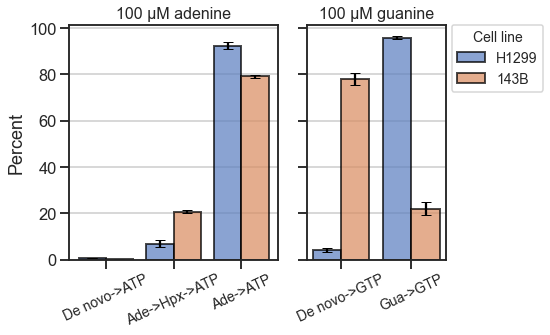

In [3]:
### Plot the purine salvage ###
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 5), gridspec_kw={'width_ratios': [3, 2]}, sharey=True)

mask = (pur_sal_frac['Salvage_metabolite'] == 'Ade')
g1 = sns.barplot(ax=ax1, y="Mean", x="Path", hue="Cell line", data=pur_sal_frac[mask], linewidth=2, edgecolor='black', alpha=0.7)

x = [i+e for i in range(0, 3) for e in [-0.2, 0.2]]
y = pur_sal_frac[mask].sort_values(by=['Path', 'Cell line'], ascending=False)['Mean'].values
yerr = pur_sal_frac[mask].sort_values(by=['Path', 'Cell line'], ascending=False)['Stdev'].values
g1.errorbar(y=y, x=x, yerr=yerr, fmt='none', color='black', capsize=5)


g1.grid(True, axis='y')
g1.set_ylabel('Percent');
g1.set_xlabel('');
g1.legend_.remove()
g1.set_xticklabels(g1.get_xticklabels(), rotation=25, size=14)
# g1.set_title('Adenine salvage', size=14)
g1.set_title('100 µM adenine', size=16)

# Plot the all other AAs:
mask2 = (pur_sal_frac['Salvage_metabolite'] == 'Gua')
g2 = sns.barplot(ax=ax2, y="Mean", x="Path", hue="Cell line", data=pur_sal_frac[mask2], capsize=.1, errwidth=2, edgecolor='black', linewidth=2, alpha=0.7)

x = [i+e for i in range(0, 2) for e in [-0.2, 0.2]]
y = pur_sal_frac[mask2].sort_values(by=['Path', 'Cell line'], ascending=(True, False))['Mean'].values
yerr = pur_sal_frac[mask2].sort_values(by=['Path', 'Cell line'], ascending=(True, False))['Stdev'].values
g2.errorbar(y=y, x=x, yerr=yerr, fmt='none', color='black', capsize=5)

g2.grid(True, axis='y')
g2.set_ylabel('');
g2.set_xlabel('');
g2.set_xticklabels(g2.get_xticklabels(), rotation=25, size=14);
g2.set_title('100 µM guanine', size=16)

# Add legend:
old_legend = g2.legend_
handles = old_legend.legendHandles
labels = ['H1299', '143B']
title = 'Sampling time'
g2.legend(handles, labels, loc='upper left', bbox_to_anchor=(1.04, 1), borderaxespad=0, fontsize=14, title='Cell line', title_fontsize=14);

# Show/save:
fig.tight_layout()
fig.savefig('output/purine_salvage.pdf', bbox_inches='tight')